In [26]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from utils import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
#import imblearn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


L'objectif est de prédire si un véhicule donné est impliqué dans un accident mortel ou non.

## Préparation du dataframe
Les attributs présents dans la base de données ne sont pas tous utiles et certains doivent être transformer avant d'être utilisé.

In [27]:
label = "mortal"

# Lecture datasets
df1 = pd.read_csv("dataset/usagers-2022.csv", sep=';')
df2 = pd.read_csv("dataset/lieux-2022.csv", sep=';')
df3 = pd.read_csv("dataset/carcteristiques-2022.csv", sep=';')
df4 = pd.read_csv("dataset/vehicules-2022.csv", sep=';')

df4 = df4.drop(columns=['id_vehicule', 'num_veh'])


df = df1.join(df2.set_index('Num_Acc'), on='Num_Acc')
df = df.join(df3.set_index('Accident_Id'), on='Num_Acc')
df = df.join(df4.set_index('Num_Acc'), on='Num_Acc', lsuffix='_')

/tmp/ipykernel_1456/1377824327.py:5: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



In [28]:
# Suppression colonnes inutiles
df = df.drop(columns=['voie', 'v1', 'v2', 'pr', 'pr1', 'lartpc', 'larrout'
                      , 'num_veh', 'occutc', 'adr', 'senc','etatp','actp', 
                      'manv', 'jour', 'com', 'hrmn', 'motor', 'place', 'vosp', 'locp'])

df = df.drop_duplicates(subset=['id_usager']) # retire les doublons dans les usagers

# Remplacement des valeurs NaN
df['an_nais'] = df['an_nais'].fillna(df['an_nais'].mode()[0])

# Convertir en entier
df['id_vehicule'] = df['id_vehicule'].apply(lambda l: l[0:3] + l[4:7])
df['id_vehicule'] = df['id_vehicule'].astype(int)
df['sexe'] = df['sexe'].astype(int)
df

,Num_Acc,id_usager,id_vehicule,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,agg,int,atm,col,lat,long,catv,obs,obsm,choc
0,202200000001,1 099 700,813952,1,3,1,2008.0,5,2,8,...,2,3,1,3,"44,5594200000","4,7257200000",2,0,2,1
1,202200000001,1 099 701,813953,1,1,1,1948.0,5,1,8,...,2,3,1,3,"44,5594200000","4,7257200000",2,0,2,1
2,202200000002,1 099 698,813950,1,4,1,1988.0,9,1,0,...,2,3,1,3,"46,9258100000","6,3462000000",7,0,2,8
3,202200000002,1 099 699,813951,1,1,1,1970.0,4,1,0,...,2,3,1,3,"46,9258100000","6,3462000000",7,0,2,8
4,202200000003,1 099 696,813948,1,1,1,2002.0,0,1,0,...,2,6,1,2,"48,4931620000","-2,7604390000",7,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126657,202200055301,968 230,715631,1,1,2,2002.0,5,1,-1,...,1,3,1,3,"43,9272650000","1,9156370000",7,0,0,8
126658,202200055301,968 231,715631,2,3,2,2004.0,5,1,-1,...,1,3,1,3,"43,9272650000","1,9156370000",7,0,0,8
126659,202200055301,968 232,715632,1,4,2,1953.0,5,1,-1,...,1,3,1,3,"43,9272650000","1,9156370000",7,0,0,8
126660,202200055302,968 228,715629,1,3,1,1992.0,1,2,6,...,2,1,1,2,"47,5944040000","1,3533290000",33,0,2,1


In [29]:
for column in df.columns:
  if df[column].isnull().values.any() == True:
    print(column, df[column].isnull().values.any()) # afficher s'il y a des valeurs nulles

In [30]:
df_2 = df.copy()

# On crée un attribut pour les accidents mortels
df_2['mortal'] = extract_mortal(df)

# Accident impliquant un piéton
has_pedestrian = df[df['catu'] == 3]
p = to_attribute(df, has_pedestrian, 1, 0)
df_2['pieton'] = p

# Sexe du conducteur
driver = df[(df['catu'] == 1) & (df['sexe'] == 1)]
dr = to_attribute(df, driver, 1, 0)
df_2['sexe_conducteur'] = dr


df_2 = df_2.drop_duplicates(subset=['id_vehicule'])

Il faut transformer les types de 'nbv', 'hrmn', 'dep', 'com', 'lat', 'long' de objets à respectivement : int, int, int, int, float, float

Pour dep et com : transformer les dpt corses pour leur donner un nom en chiffre et non en lettre (2A/2B)

In [31]:
# On réduit les carégories de véhicules
df_2 = simplify_catv(df_2)

# On enlève la catégorie peu repésentées qu'on ajoute dans une catégorie autre (identifiant 5)
df_2 = simplify_catr(df_2)

# Découpage en 4 catégories de vitesse
df_2 = split_vma(df_2)

        
# Département en entiers
df_2['dep'] = df_2['dep'].apply(transforme_dpt)
df_2['dep'] = pd.to_numeric(df_2['dep'], errors='coerce', downcast='integer')

# nbv en entier
df_2['nbv'] = pd.to_numeric(df_2['nbv'], errors='coerce', downcast='integer')
df_2['nbv'].fillna(2, inplace=True) # only one entry 
df_2['nbv'] = pd.to_numeric(df_2['nbv'], errors='coerce', downcast='integer')

# Lat et long en float :
df_2['lat'] = pd.to_numeric(df_2['lat'], errors='coerce')
df_2['long'] = pd.to_numeric(df_2['long'], errors='coerce')

# Age du conducteur du véhicule
df_2['age'] = get_driver_age(df_2)
df_2['age'] = df_2['age'].fillna(df_2['age'].mode()[0])
df_2['age'] = pd.to_numeric(df_2['age'], errors='coerce', downcast='integer')

# Réduire les valeurs de trajet
df_2['trajet'] = reduce_trajet_values(df_2)

# Réduire les valeurs de surf
df_2['surf'] = reduce_surf_values(df_2)

# obs prend pour valeur 0 si obstacle 1 si pas d'obstacle
df_2['obs'] = reduce_obs_values(df_2)

# On enlève les attributs qui ne sont plus utiles
df_2 = df_2.drop(columns=['an_nais','grav', 'sexe','catu', 'id_usager', 'id_vehicule',
                          'secu1','secu2','secu3', 'an', 'lat', 'long'])

In [32]:
# Tri manuel des valeurs catégorielles/numériques

# valeurs catégorielles
categorical_features = ['trajet', 'catr', 'circ', 'nbv', 'prof',
                        'plan', 'surf', 'vma', 'lum', 'agg', 
                        'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton',
                        'sexe_conducteur', 'infra', 'situ']
# valeurs numériques
numerical_features = ['mois', 'dep','age']

print("numerical : ", numerical_features)
print("categorical : ", categorical_features)

numerical :  ['mois', 'dep', 'age']
categorical :  ['trajet', 'catr', 'circ', 'nbv', 'prof', 'plan', 'surf', 'vma', 'lum', 'agg', 'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton', 'sexe_conducteur', 'infra', 'situ']


## Analyse de données

In [33]:
val = [len(df_2[df_2.mortal == 1]), len(df_2[df_2.mortal == 0])]
labels = ['Accident mortel', 'Accident non mortel']
px.pie(values=val, names=labels)

In [34]:
val = [len(df_2[df_2.pieton == 1]), len(df_2[df_2.pieton == 0])]
labels = ['Implique piéton', 'N\'implique pas de piéton']
px.pie(values=val, names=labels)

In [ ]:
fig = px.histogram(df_2, x="catv")
fig.show()

fig = px.box(df_2, x="age")
fig.show()

fig = px.histogram(df_2, x="sexe_conducteur")
fig.show()

fig = px.histogram(df_2, x="catr")
fig.show()

fig = px.histogram(df_2, x="col")
fig.show()

fig = px.histogram(df_2, x='obs')
fig.show()

In [ ]:
features = ['age', 'mois', 'catr', 'mortal', 'sexe_conducteur']

for exp in features:
    print(exp)
    analyse_bi_quali_quanti("catv", exp, df_2)

In [ ]:
features = ['age', 'mois', 'catr', 'mortal']

for exp in features:
    print(exp)
    analyse_bi_quali_quanti("vma", exp, df_2)

In [ ]:
features = ['age', 'vma', 'mois', 'catr', 'mortal']

for exp in features:
    print(exp)
    analyse_bi_quali_quanti("col", exp, df_2)

## One hot encoding

In [35]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

## Apprentissage avec un arbre de décision

In [36]:
from sklearn.model_selection import train_test_split

# On découpe le jeu de données tout en conservant ensemble les véhicules impliqué dans un même accident
# Les données d'entrainement et de test n'ont donc pas de rapport direct

unique_accidents = df_2['Num_Acc'].unique() # Num_Acc uniques

df_3 = df_2.drop(columns=['mortal'])
# Création des train et test set à partir des numéros d'accident
X_train, X_test = train_test_split(unique_accidents, test_size=0.33, random_state=42)

# On peut ensuite récupérer les véhicules correspondants aux accidents
train_df = df_2[df_2['Num_Acc'].isin(X_train)]
test_df = df_2[df_2['Num_Acc'].isin(X_test)]
y_train = train_df['mortal']
y_test = test_df['mortal']
X_train = train_df.drop(columns=['mortal', 'Num_Acc'])
X_test = test_df.drop(columns=['mortal', 'Num_Acc'])
df_2 = df_2.drop(columns='Num_Acc')

In [37]:
# Ici on autorise la spération des véhicules impliqué dans un même accident
# Source de biais

#df_3 = df_2.drop(columns=['mortal'])
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(df_3, df_2[label], test_size=0.33, random_state=42)

In [38]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(random_state=42)
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', dt)])
clf = clf.fit(X_train, y_train)

preds = clf.predict(X_test)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.9013821321563195)

In [39]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
tn, fp, fn, tp

(27687, 1648, 1413, 291)

In [40]:
import plotly.express as px


fig = px.imshow([[tn, fp], [fn, tp]], text_auto=True, labels=dict(y="Truth", x="Pred"),
                x=["False", "True"],
                y=["False", "True"]
               )
fig.show()

## Générer des contrefactuels

In [41]:
import pickle

data_test = X_test.copy(deep=True)
data_test["Y"] = y_test

data_test.to_csv("test_data.csv",
          index=False)

data_train = X_train.copy(deep=True)
data_train["Y"] = y_train

data_train.to_csv("train_data.csv",
          index=False)

with open( 'clf.pickle', 'wb' ) as f:
    pickle.dump(clf, f )

In [ ]:
import dice_ml
from dice_ml.utils import helpers

In [ ]:
train_dataset = df_2.copy()
train_dataset[label] = y_train
d = dice_ml.Data(dataframe=train_dataset, continuous_features=numerical_features, outcome_name=label)

m = dice_ml.Model(model=clf, backend="sklearn")

exp = dice_ml.Dice(d, m)

In [ ]:
# Génération des contrefactuels
for i in range(5):
  query_instance = data_test.drop(columns="Y")[i:i+1]
  dice_exp = exp.generate_counterfactuals(
      query_instance,
      total_CFs=10,
      desired_class="opposite")
  # Visualize counterfactual explanation
  dice_exp.visualize_as_dataframe(show_only_changes=True)
  # Instance local feature importance
  imp = exp.local_feature_importance(query_instance, cf_examples_list=dice_exp.cf_examples_list)
  print(imp.local_importance)

In [ ]:
from BlackBoxAuditing.data import load_from_file
from BlackBoxAuditing.model_factories.AbstractModelFactory import AbstractModelFactory
from BlackBoxAuditing.model_factories.AbstractModelVisitor import AbstractModelVisitor

import BlackBoxAuditing as BBA


(_, train_BBA, _, _, _, _) = load_from_file("train_data.csv",
                      correct_types = np.repeat([int], [len(data_test.columns)]),
                                response_header = 'Y',
                               train_percentage = 1.0)
(headers, _, test_BBA, response_header, features_to_ignore, correct_types) = load_from_file("test_data.csv",
                      correct_types = np.repeat([int], [len(data_test.columns)]),
                                response_header = 'Y',
                               train_percentage = 0.0)
BBA_data = (headers, train_BBA, test_BBA, response_header, features_to_ignore, correct_types)

In [ ]:
class HirePredictorBuilder(AbstractModelFactory):
    def __init__(self, *args, **kwargs):
        AbstractModelFactory.__init__(self, *args, **kwargs)
        self.verbose_factory_name = "HirePredictor"
    def build(self, train_set):
        return HirePredictor()

class HirePredictor(AbstractModelVisitor):
    def __init__(self):
        with open( 'clf.pickle', 'rb' ) as f:
            self.clf = pickle.load(f)

    def test(self, test_set, test_name=""):
        df_test = pd.DataFrame(
            test_set, columns =data_test.columns.to_list())
        targets = df_test['Y']
        preds = self.clf.predict(df_test.drop('Y', axis=1))
        return [[a,b] for (a,b) in zip(targets, preds)]

In [ ]:
auditor = BBA.Auditor()
auditor.ModelFactory = HirePredictorBuilder
auditor(BBA_data, output_dir = "audit-output")

In [42]:
cols = data_test.columns.to_list()
cols.remove('Y')
cols

['trajet',
 'catr',
 'circ',
 'nbv',
 'prof',
 'plan',
 'surf',
 'infra',
 'situ',
 'vma',
 'mois',
 'lum',
 'dep',
 'agg',
 'int',
 'atm',
 'col',
 'catv',
 'obs',
 'obsm',
 'choc',
 'pieton',
 'sexe_conducteur',
 'age']

In [43]:
def predictproba_fn(data, clf=clf, columns=cols):
  df_test = pd.DataFrame(
            [data], columns=columns )
  preds = clf.predict_proba(df_test)
  return np.squeeze(preds, axis=0)
fc = lambda x: predictproba_fn(x)[1]

In [44]:
query_instance = data_test.drop(columns="Y")[0:1]
x_class = int(clf.predict(query_instance))
query_instance=query_instance.squeeze()
print(query_instance)
print()
print("Prediction for x: {0:.0f}".format(x_class))

trajet              0
catr                4
circ                2
nbv                 2
prof                1
plan                1
surf                1
infra               0
situ                1
vma                 2
mois               10
lum                 1
dep                25
agg                 2
int                 3
atm                 1
col                 3
catv                3
obs                 0
obsm                2
choc                8
pieton              0
sexe_conducteur     1
age                34
Name: 2, dtype: int64

Prediction for x: 0


/tmp/ipykernel_1456/533814558.py:2: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [45]:
fc(query_instance.values)

0.0

In [46]:
X_opposite_class = X_train[clf.predict(X_train) != x_class].copy()
reference = X_opposite_class.sample()
ref_class = int(clf.predict(reference))
reference=reference.squeeze()
print(reference)
print()
print("Prediction for this reference: {0:.0f}".format(ref_class))

trajet              0
catr                3
circ                2
nbv                 2
prof                1
plan                1
surf                1
infra               0
situ                1
vma                 3
mois                4
lum                 1
dep                 1
agg                 1
int                 3
atm                 1
col                 3
catv                3
obs                 1
obsm                2
choc                1
pieton              0
sexe_conducteur     0
age                22
Name: 49593, dtype: int64

Prediction for this reference: 1


/tmp/ipykernel_1456/2782652181.py:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [47]:
fc(reference.values)

1.0

In [54]:
from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley, MonteCarloShapleyBatch
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

true_shap = MonteCarloShapley(x=query_instance, fc=fc, ref=reference, n_iter=4000)

new dimension 9


  0%|          | 0/4000 [00:00<?, ?it/s]

 33%|███▎      | 1332/4000 [01:55<03:48, 11.69it/s]

In [52]:
true_shap

trajet             0.000
catr               0.092
circ               0.000
nbv                0.000
prof               0.000
plan               0.000
surf               0.000
infra              0.000
situ               0.000
vma                0.000
mois               0.000
lum                0.000
dep               -0.404
agg               -0.269
int                0.000
atm                0.000
col                0.000
catv               0.000
obs               -0.419
obsm               0.000
choc               0.000
pieton             0.000
sexe_conducteur    0.000
age                0.000
dtype: float64

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



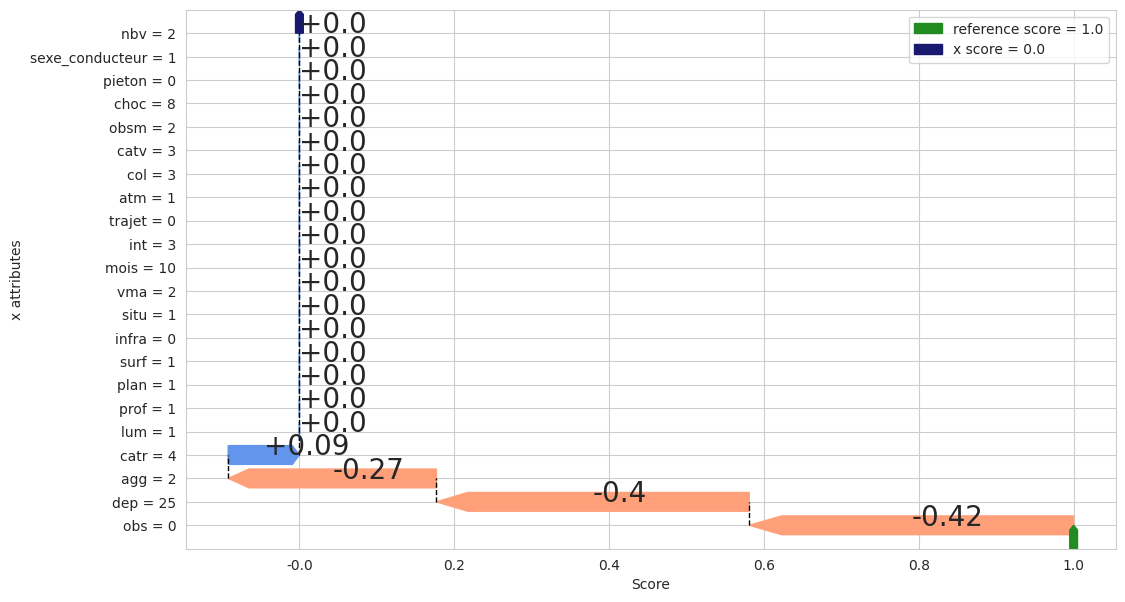

In [53]:
fig =  plot_shapley(x=query_instance, fc=fc, ref=reference, shapley_values=true_shap, n_attributes=22)